# 0. Imports

Except for Keras, there should be no unusual dependencies here. All of these libraries are part of the standard scienctific python toolset.

In [1]:
%matplotlib inline 

#generic python libraries
import os
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from itertools import product

#using sklearn for general machine learning
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Ridge
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

#Using keras for deep learning
from keras.models import Sequential
from keras.layers.core import Flatten, Merge, Dense, Dropout
from keras.layers.convolutional import Convolution1D

Using TensorFlow backend.


# 1. Introduction

At first, this challenge seemed daunting. Having little background in molecular biology, I wasn't sure how well I would do. But as I progressed, I realised this mattered less than I expected. It is the data that informs our knowledge about the biology, more than the other way around! 

This presentation will be broken into two main parts

1. Riley suggested that it would be interesting to look for patterns within the sequences themselves, so that will be the topic of the first section. First we will look at high level aggregated data to see if there is anything interesting to find there. Then we will look at the unaggregated data and attempt to find patterns in individual sequences.

2. In the next section, we will focus on predicting sequence guide activity level. We will try models of varying complexity, from simple linear models to deep models.

One small caveat to this presentation is that due to time and hardware limitations, I have not analysed any ngrams larger than trigrams

# 2. Sequence Analysis

In this section, we will begin our exploration of the spacer sequences. The first step is, of course, to load the dataset.

In [2]:
data = pd.DataFrame.from_csv('data/example_guide_data.tsv', sep='\t')

To begin our analysis we need to chop the sequences up into some other form that we can analyse. First we'll generate a table with a row for every ngram, and a column for each possible position. Every cell of the table represents the number of times the ngram appears in that position. 

In [3]:
def ngram_table(data, n):
    ngrams_list = map(lambda x: ''.join(x), product('ATCG', repeat=n))
    ngram_id = dict(zip(ngrams_list, range(4 ** n)))
    ngram_locations = range(21 - n)
    ngram_table = np.zeros((len(ngrams_list), len(ngram_locations)))
    
    for gene, sequence in data.spacer_seq.iteritems():
        for i in ngram_locations:
            ngram = sequence[i:i+n]
            ngram_table[ngram_id[ngram], i] += 1

    return pd.DataFrame(ngram_table, index=ngrams_list, columns=ngram_locations)

In [4]:
unigram_table = ngram_table(data, 1)
bigram_table  = ngram_table(data, 2)
trigram_table = ngram_table(data, 3)

This is what the table of trigrams (i.e codons) looks like

In [5]:
trigram_table.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
AAA,824,830,770,771,843,746,812,854,775,853,979,893,895,994,896,947,1007,901
AAT,742,725,686,686,723,657,792,745,674,736,840,797,804,853,800,765,860,478
AAC,806,930,850,785,921,851,710,938,846,745,935,937,855,984,878,808,979,1287
AAG,826,1082,970,793,1070,1007,794,1079,1031,797,1115,1073,831,1143,1097,784,1123,1073
ATA,587,703,647,633,743,674,597,709,644,567,643,671,618,634,662,645,679,505


### Structure Outlines

Now that we have organised our data into a meaningful format, we can begin to look for some high level structures to the data, such as which ngrams typically appear where.

Specifically, we'll plot the distribution of codons at each position. Some codons (about 40%) aren't paricularly interesting, i.e they don't appear in any one spot particularly more than any other. Lets filter them out

In [6]:
def table_row_is_interesting(table, row):
    return any((row < np.percentile(table, 10)) | (row > np.percentile(table, 90)))

def filter_interesting_rows(table):
    return table[table.apply(lambda row: table_row_is_interesting(table, row), axis=1)]

We can quickly analyse the distribution of each codon using a hierarchically clustered heatmap. This will organise rows and columns by similarity.

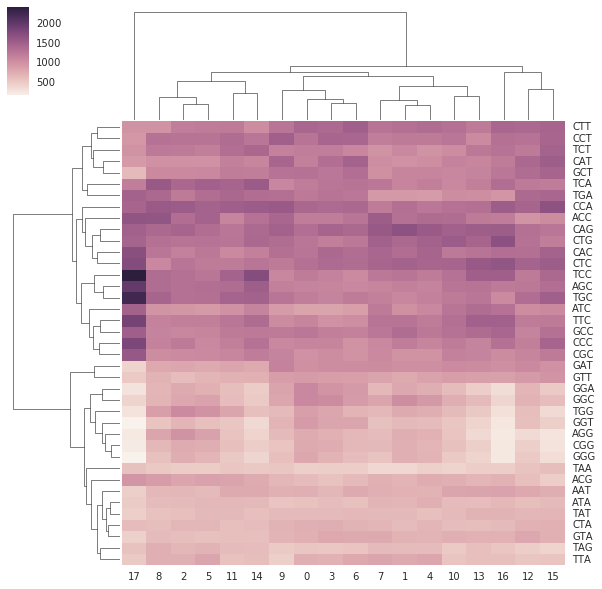

In [7]:
plot = sea.clustermap(filter_interesting_rows(trigram_table))
plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

It is immediately clear that the relative distribution of codons is vastly different in the final (17th) position

We can see that the TCC, AGC, and TGC codons are massively more common in the last position than anywhere else. In fact, C and CC are the most likely unigram and bigram at the end of the sequence. Similarly, we can see GGG, CGG, or any codon ending in GG very rarely appears in the final position. 

Interestingly, there are no similar anomalies in the distribution at the start of the sequence.

### Fine grained structure

Previously, we chopped the sequences into parts then aggregated them together. This revealed some general information about where codons typically appear in the sequences, but there are plenty more interesting questions that we can ask. Perhaps sequences that start with one codon typically end with another.

To answer questions like this, we need to chop our data into finer parts. To do this we one-hot encode all ngrams for every sequence. The table we generate in this step will have one row for every sequence in the original dataset, and will have a column for every position any ngram could appear.

In [8]:
def ngram_one_hot_encode(data, n):
    num_ngrams    = 4 ** n
    num_locations = 21 - n  
    
    ngrams_list   = map(lambda x: ''.join(x), product('ATCG', repeat=n))
    ngram_id      = dict(zip(ngrams_list, range(num_ngrams)))
    one_hot_table = np.zeros((len(data), num_locations * num_ngrams))
    
    for i, (gene, sequence) in enumerate(data.spacer_seq.iteritems()):
        for j in range(num_locations):
            ngram = sequence[j:j+n]
            one_hot_table[i, j * num_ngrams + ngram_id[ngram]] += 1

    # create column names 00_AAA, 00_AAT, ... , 17_GGG            
    column_names = map(lambda x: ''.join(x), product(map(lambda i: str(i).zfill(2) + '_', range(num_locations)), ngrams_list))
    
    return pd.DataFrame(one_hot_table, index=data.index, columns=column_names)

In [9]:
trigrams = ngram_one_hot_encode(data, 3)

The table below shows the first five lines of the encoded trigrams. There are 1152 (18 * (4^3)) columns in this dataset. 18 possible positions for any trigram, and 4^3 possible trigrams

In [10]:
trigrams.head(5)

,00_AAA,00_AAT,00_AAC,00_AAG,00_ATA,00_ATT,00_ATC,00_ATG,00_ACA,00_ACT,...,17_GTC,17_GTG,17_GCA,17_GCT,17_GCC,17_GCG,17_GGA,17_GGT,17_GGC,17_GGG
gene_name,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now have a very large sparse matrix. Datasets like this are notoriously difficult to visualise, but the best bet is probably tSNE. tSNE is a state of the art algorithm designed specifically for reducing high dimensional datasets to 2 or 3 dimensions for plotting. It has had massive success in plotting word vectors.

The implementation in sklearn isn't terribly fast, and appears to slow down exponentially as the number of rows increases (even though the algorithm should be nlogn). Because of this, I opted to sample just some of the rows in the table to see if any obvious distribution falls out. I also color coded the scatter plot so that sequences with a high Day 7 (rep 1) guide activity are red, and those with a low guide activity are green.

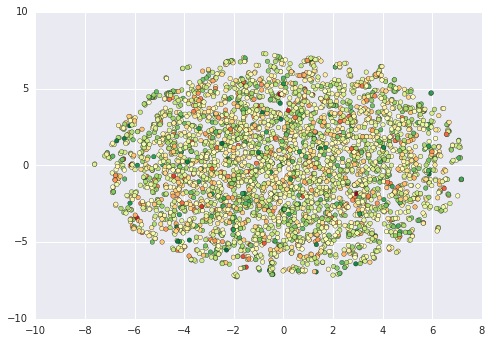

In [11]:
indicies = np.random.choice(range(len(trigrams)), 4000, replace=False)
tsne_trigrams = TSNE().fit_transform(trigrams.take(indicies))
plt.scatter(*zip(*tsne_trigrams), c=np.log(data.norm_count_D7_Rep1.take(indicies)), cmap=plt.cm.RdYlGn_r)

No obvious pattern emmerges from the data. This does not bode well for finding patterns within individual sequences.

## A Codon Recommendation Engine

Even though tSNE failed to display provide any interesting visualisations, it does not mean that there are no patterns to be found within individual sequences. My next idea to tackle this problem was to build a simple recommendation engine for codons in a sequence. We will be predicting the probability that a certain codon appears in the sequence, given the other codons that appear in the sequence. If we are able to predict this, it would mean that some codons could predict the existence or non existence of another. This would be a very interesting discovery!

To do this, for every column in the one-hot encoded trigrams dataset used above, I trained a model from all other (non overlapping) columns. This gave me 1152 models (one for every trigram at every position) that would predict whether or not a trigram appeared in a particular position.

In [12]:
#we don't want to include intersecting columns in the prediction, as these
#would include some knowledge about the codon they are trying to predict
def intersecting_columns(columns, col):
    return filter(lambda x: abs(int(col[:2]) - int(x[:2])) < 3, columns)

In [13]:
#this was, predictably, a long running computation. I saved the results as a csv to avoid rerunning this every time
if os.path.isfile('prediction_scores.csv'):
    prediction_score_list = pd.Series.from_csv('prediction_scores.csv', header=None, index_col=None).values
else:
    prediction_score_list = []
    scorer = make_scorer(cohen_kappa_score)
    for col in trigrams.columns:
        interfering_cols = intersecting_columns(trigrams.columns, col)
        x = trigrams.drop(interfering_cols, axis=1)
        y = trigrams[col]
        prediction_score = np.mean(cross_val_score(MultinomialNB(), x, y, scoring=scorer, cv=5))
        prediction_score_list2.append(prediction_score)

        print prediction_score

It would be tempting here to report that most of these models were above 98% accurate. While that is true, it is misleading. If 98% of the time a trigram doesn't appear in a given position, then any dumb model always predicting False would achieve the same score. Accuracy is not a valid metric here.

Instead, I opted to use Cohen's Kappa. This metric controls for agreement between our model and the true model occuring purely by chance.

The significance threshold for a kappa score is commonly set to around 0.4. Any less than that and it is question whether or not the model has learned anything intelligent. Lets look at how our models did.

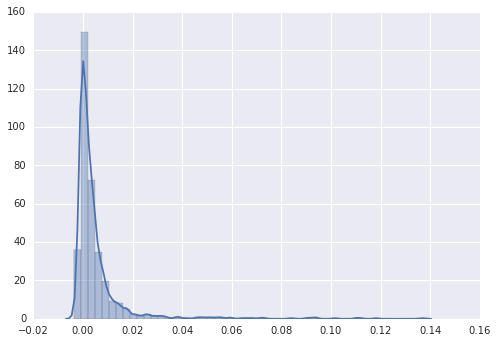

In [14]:
sea.distplot(prediction_score_list)

And the top 3 models

In [15]:
pd.DataFrame({'scores' :prediction_score_list}, trigrams.columns).sort_values('scores', ascending=False).head(3)

,scores
09_ACC,0.137190
05_ACT,0.118096
07_ACC,0.111780


Not good. Although there is one slight outlier (the model predicting ACC at position 9), its kappa score, and all of the others, is so low that it probably makes more sense to dismiss it as noise.

This is unfortunate. Both attempts to find structure within individual sequences have failed. I believe that this requires more research, and quite possible a better background in molecular biology than what I have.

# 3. Prediction

The next step will be all about predicting the guide activity of a sequence.

We will closely follow the methodology of Fusi, Smith, et al used in their paper "In Silico Predictive Modeling of CRISPR/Cas9 guide efficiency". They recommend using spearman correlation to gauge the accuracy of prediction. Spearman correlation is a measure of how closely the rankings of two results are correlated. i.e, is the nth best guide in the true model likely to be the nth best guide in our model. In this way we can get a sense of how good we are at finding the best spacer sequence, rather predicting the raw guide activity numbers.


The dataset provided 9 separate readings of guide activity. Because of time constraints, I only focused on predicting one, the first replication of the day 7 count with no PLX. This should not be a major issue, as the rankings of the guides is highly correlated between all trails, as shown below.

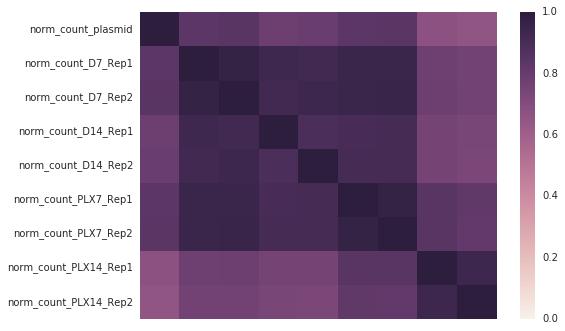

In [16]:
spearman_corr_matrix = np.zeros((9, 9))
columns = data.drop(['spacer_id', 'spacer_seq'], axis=1).columns
for i, col_a in enumerate(columns):
    for j, col_b in enumerate(columns):
        spearman_corr_matrix[i, j] = spearmanr(data[col_a], data[col_b]).correlation
        
sea.heatmap(spearman_corr_matrix, yticklabels=columns, xticklabels=[], vmin=0, vmax=1)

Our features will come purely from the sequence itself. I have not used any external data in this presentation. First, we will one-hot encode all unigrams , bigrams, and trigrams, then combine them to form our working dataset.

In [17]:
unigrams = ngram_one_hot_encode(data, 1)
bigrams  = ngram_one_hot_encode(data, 2)
trigrams = ngram_one_hot_encode(data, 3)

sequence_data = pd.concat([unigrams, bigrams, trigrams], axis=1)
sequence_data.shape

(64076, 1536)

The first model we will try using is a simple linear regression model with l2-regularization. In Sklearn, this is called Ridge regression.

In [18]:
scores = []
#we will cross validate using 10 folds to ensure a valid result
for (train, test) in KFold(len(data), 10):
    x_train = sequence_data.ix[train]
    y_train = data.norm_count_D7_Rep1.ix[train]
    
    x_test = sequence_data.ix[test]
    y_test = data.norm_count_D7_Rep1.ix[test]
    
    model = Ridge()
    model.fit(x_train, y_train)
    score = spearmanr(y_test, model.predict(x_test))
    scores.append(score)
    
np.mean([result.correlation for result in scores])

0.58085271935301286

This simple model preforms very well. To put this result into perspective, consider the results reported in the aforementioned paper. Their best model reports a mean performance of about .5, while ours is at a comfortable .58.

![title](results.PNG)

Admittidely, this is more likely to do with the quality of the data provided rather than anything intelligent that I have done here. After all, all I have done is encode the data in a table and used a simple out of the box model. Our result is robust though, the model even gets a mean spearman correlation of .59 on the replicate day 7 data.

In [19]:
spearmanr(data.norm_count_D7_Rep2, model.predict(sequence_data))

SpearmanrResult(correlation=0.59039631129299508, pvalue=0.0)

There is a benifit to using simple models however, that is their explainability. We can dig into the coefficients learned by the linear model to understand what features it thought were the postitive, and negative, predictors of guide activity.

In [20]:
#no need for cross validation here, we'll use the whole dataset
model = Ridge()
model.fit(sequence_data, data.norm_count_D7_Rep1)
lr_data = pd.Series(model.coef_, index=sequence_data.columns)

The top 10 most predictive features were as follows.

Reminder: The format of the features was XY_Z where XY denotes the position in the sequence, and Z denotes the ngram in question

In [21]:
lr_data.sort_values(ascending=False).head(10)

19_T      2.466119
16_CAT    2.460463
00_T      2.259856
04_ACG    2.020043
12_ATG    1.996901
18_T      1.994312
06_CCT    1.981699
07_ACG    1.946247
07_CCT    1.887029
19_C      1.831324
dtype: float64

And the 10 most negative predictors

In [22]:
lr_data.sort_values().head(10)

16_GGT   -2.607110
16_TTT   -2.337100
00_G     -2.329059
19_A     -2.189618
14_GGT   -2.152148
19_G     -2.107825
08_CGG   -2.044448
18_G     -2.003401
15_CGG   -1.979761
16_CGG   -1.904691
dtype: float64

At this point, I tried using some more complex models such as KNN, Random Forest Ensembles, and support vector machines. However none of them performed much better than the linear model, and took orders of magnitude longer to run. Searching for, and cross validating, the best set of parameters for these models was infeasible. 

## Deep Learning

The application of deep learning in the field of molecular biology promises to be a huge area of research in the future.

We will attempt to replicate, or improve upon, our results using the linear regression model with a deep learning model. In this section I will be using the Keras library which is a fantastically simple to use deep learning library. It can be set to use Tensorflow as the backend, which I have done so on my local machine.

Our model will work with the same sequence_data dataset as before, but we will divide it into three sets. We will have a training set, a validation set, and a test set. These three divisions are important. The training set will be used to tune the parameters of the model, the validation set will be used to learn roughly when to stop training the model, and the training set will provide an unbiased evaluation of the model.

In [23]:
sequence_data.shape

(64076, 1536)

The first model we will try is a simple fully connected model. The dropout layers in between will improve generalisation and curb over fitting. Again, we will only try to predict the Day 7 guide activity.

In [24]:
model = Sequential()
model.add(Dense(1536, activation='relu', input_dim=1536))
model.add(Dropout(0.5))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

#We will use Mean Absolute Percentage Error as our loss metric
#Optimizing this should be close to optimizing spearman correlation
model.compile(optimizer='adam', loss='mape')

In [25]:
x_train, x_test, y_train, y_test = train_test_split(sequence_data, data.norm_count_D7_Rep1, test_size=0.2, random_state=42)
x_train, x_val,  y_train, y_val  = train_test_split(x_train, y_train, test_size=0.2, random_state=43)

In [26]:
train_losses = []
val_losses   = []
for _ in range(2):
    history = model.fit(x_train.values, y_train, batch_size=1024, nb_epoch=5, validation_data=(x_val.values, y_val))
    train_losses += history.history['loss']
    val_losses += history.history['val_loss']
    print 'train spearman corr:', spearmanr(model.predict(x_train.values), y_train)
    print 'validation spearman corr:', spearmanr(model.predict(x_val.values), y_val)

Train on 41008 samples, validate on 10252 samples
Epoch 1/5
41008/41008 [==============================] - 38s - loss: 55.2335 - val_loss: 48.9755
Epoch 2/5
41008/41008 [==============================] - 36s - loss: 47.2458 - val_loss: 47.5163
Epoch 3/5
41008/41008 [==============================] - 38s - loss: 45.4605 - val_loss: 47.0819
Epoch 4/5
41008/41008 [==============================] - 37s - loss: 43.6290 - val_loss: 46.7890
Epoch 5/5
41008/41008 [==============================] - 37s - loss: 41.3776 - val_loss: 46.8592
train spearman corr: SpearmanrResult(correlation=0.682216026841722, pvalue=0.0)
validation spearman corr: SpearmanrResult(correlation=0.58667556097124263, pvalue=0.0)
Train on 41008 samples, validate on 10252 samples
Epoch 1/5
41008/41008 [==============================] - 36s - loss: 39.3241 - val_loss: 47.4733
Epoch 2/5
41008/41008 [==============================] - 37s - loss: 37.6143 - val_loss: 48.4917
Epoch 3/5
41008/41008 [==============================]

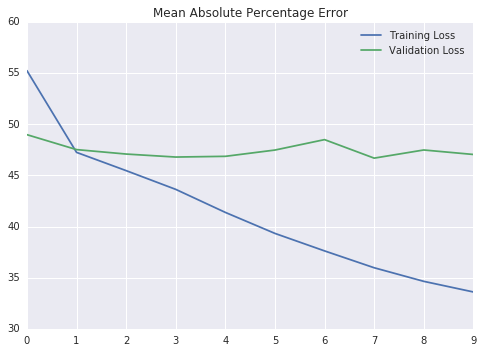

In [27]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Mean Absolute Percentage Error')
plt.legend()

In [28]:
spearmanr(model.predict(x_test.values), y_test)

SpearmanrResult(correlation=0.57243533521342516, pvalue=0.0)

This very simple deep model quickly reaches the level of spearman correlation of the linear model, but with about 30% less training data! However it appears to overfit quickly, even with a 50% dropout rate between layers. We need to change the structure of the model.

Deep models are usually more successful when they are built in such a way as to replicate how we as humans might attack the problem.

What we want the model to really learn is patterns in the DNA sequence. For example, we want it to learn that a special sequence some of 3 bases, i.e a codon, means that this sequence is likely to have a higher or lower guide activity. We can replicate that thought process in the way we build our model.

Our model should be suited then to recognising patterns. Here, we can tap into some of the recent developments in the now hugely successful field of Computer Vision. We will use Convolutional neural nets to find patterns within the sequence of dna, just as it might find patterns in the pixels of an image. Keeping with the analogy of images, we will structure our data so that it will look like a row of 20 pixels (bases), and each pixel will have 4 possible colors - A, T, G, or C.

In [29]:
def format_sequences(sequences):
    base_ids = {'A':0, 'T':1, 'G':2, 'C':3}
    data_matrix = np.zeros((len(sequences), 20, 4))
    for i, sequence in enumerate(sequences):    
        for j, base in enumerate(sequence):
            data_matrix[i, j, base_ids[base]] = 1
    return data_matrix

In [30]:
model1 = Sequential()
model1.add(Convolution1D(64, 1, border_mode='same', input_shape=(20, 4), activation='relu'))
model1.add(Flatten())

model2 = Sequential()
model2.add(Convolution1D(64, 2, border_mode='same', input_shape=(20, 4), activation='relu'))
model2.add(Flatten())

model3 = Sequential()
model3.add(Convolution1D(64, 3, border_mode='same', input_shape=(20, 4), activation='relu'))
model3.add(Flatten())

model = Sequential()
model.add(Merge([model1, model2, model3], mode='concat'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='nadam', loss='mape')

In [31]:
x_train, x_test, y_train, y_test = train_test_split(format_sequences(data.spacer_seq), data.norm_count_D7_Rep1, test_size=0.2, random_state=42)
x_train, x_val,  y_train, y_val  = train_test_split(x_train, y_train, test_size=0.2, random_state=43)

In [32]:
train_losses = []
val_losses   = []
for i in range(4):
    history = model.fit([x_train, x_train, x_train], y_train, batch_size=1024, nb_epoch=5, validation_data=([x_val, x_val, x_val], y_val))
    train_losses += history.history['loss']
    val_losses += history.history['val_loss']
    print 'train spearman corr:', spearmanr(model.predict([x_train, x_train, x_train]), y_train)
    print 'validation spearman corr:', spearmanr(model.predict([x_val, x_val, x_val]), y_val)

Train on 41008 samples, validate on 10252 samples
Epoch 1/5
41008/41008 [==============================] - 71s - loss: 57.3054 - val_loss: 80.6359
Epoch 2/5
41008/41008 [==============================] - 71s - loss: 53.4778 - val_loss: 52.6938
Epoch 3/5
41008/41008 [==============================] - 71s - loss: 51.7316 - val_loss: 57.7795
Epoch 4/5
41008/41008 [==============================] - 71s - loss: 50.9024 - val_loss: 48.5021
Epoch 5/5
41008/41008 [==============================] - 73s - loss: 50.2754 - val_loss: 48.0590
train spearman corr: SpearmanrResult(correlation=0.58691064675248794, pvalue=0.0)
validation spearman corr: SpearmanrResult(correlation=0.57119155998056703, pvalue=0.0)
Train on 41008 samples, validate on 10252 samples
Epoch 1/5
41008/41008 [==============================] - 73s - loss: 49.7710 - val_loss: 65.4195
Epoch 2/5
41008/41008 [==============================] - 71s - loss: 49.9746 - val_loss: 49.6147
Epoch 3/5
41008/41008 [=============================

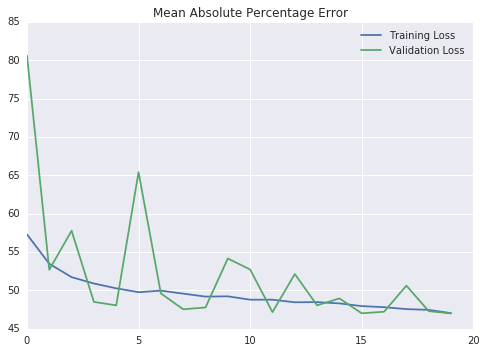

In [33]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Mean Absolute Percentage Error')
plt.legend()

In [34]:
spearmanr(model.predict([x_test, x_test, x_test]), y_test)

SpearmanrResult(correlation=0.58343175958499416, pvalue=0.0)

The results are, a little disappointingly, very similar to our previous models. However we have drastically reduced overfitting compared to the previous deep learning model. This suggests that this model has a good structure, and that the problem might well exist elsewhere. I will explain where I believe this problem lies in the conclusion.

# 4. Conclusion

In this presentation we started by investigating the sequences first on a high level then at a finer level. On a high level, we found that some codons and sequences of bases occur much more, or less, regularly in some positions than others. However when looking at individual sequences, we were unable to find convincing evidence that we could predict the existence or non existence of a codon given the rest of the sequence. This would suggest patterns within the sequences themselves may be quite ellusive, but this is certainly worthy of more investigation. 

Then we moved on to predicting the guide activity level of a sequence, or at least their relative rankings. We had a substantial result with our very simple model, with a spearman correlation coefficient of about .58, equalling state of the art results. From this linear regression model we looked breifely into some codons that were strong positive or negative predictors of guide activity.

Then we attempted a deep learning approach hoping to do better than the simple linear regression model, but only managed to equal it. It was certainly an interesting excercise though!

What was left undocumented were the many attempts at using different model types such as KNN, Random Forest Ensembles, and Support Vector Machines to improve our result. As stated earlier, none of these models appear to be much better than linear regression. It is clear that no matter how simple or complex the model, and given the data we were working with, we were never going to reach far above .60 spearman correlation. This indicates that this problem is not going to be solved by a magic bullet model. There is also evidence that adding additional data won't benefit the model performance, as shown in the graph below. We can estimate how much any additonal data will benefit us by looking at the performance of a number of models trained on an increasing dataset.

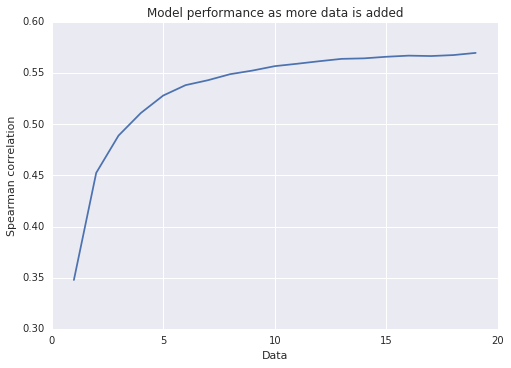

In [36]:
scores = []
x_train, x_test, y_train, y_test = train_test_split(sequence_data, data.norm_count_D7_Rep1, test_size=0.2, random_state=42)
for num_rows in np.linspace(1, len(x_train), 20).astype(int):
    model = Ridge()
    model.fit(x_train[:num_rows], y_train[:num_rows])
    scores.append(spearmanr(model.predict(x_test), y_test))
plt.plot([score.correlation for score in scores])
plt.title('Model performance as more data is added')
plt.ylabel('Spearman correlation')
plt.xlabel('Data')

We can clearly see that there is diminishing returns for additional data. 

Because of the aforementioned points, it is my view that to make progress into predicting guide activity of sequences, that we should not focus on smarter models, or additional data, but better features. I do not believe much further progress could be made using features derived only from the sequences themselves.

Before I conclude, I would also like to say a word about word2vec. Word2vec has produced some truely astounding results in the natural language space over the last number of years. It gives us the ability to group words together by their concept in a completely unsupervised way. I spoke to Riley about its application to genetics, and I think it could lead to something really fascinating. I wanted to give it a go in this presentation, but decided against it. Firstly from my own experience, I'm not sure that this dataset would be big enough to produce any meaningful results. However, the vocabularly is obviously much smaller here than in the english language, so i could be wrong about that. Secondly, again from my own experience, is that I probably don't have adequate hardware to build and train a successful word2vec model. I am running a Linux VM from a windows host on a somewhat modest gaming laptop. Not an ideal setup for deep learning purposes, as it makes using the GPU completely impossible. With the proper resources, I would love to try this out though.

This excercise has been extraordinary interesting, and I have learned more than I could have imagined. I only hope that I can continue exploring this field in the future. 

Mark